In [2]:
def get_word_scores_from_file(filepath, word_col, value_cols, value_calculation=(lambda x: x[0]), filter_dict=None, file_delimiter=",", 
                              aggregate_by_mean=False, aggregate_by_count=False, convert_value=(lambda val: 0.0 if val == "" else float(val)), latindecode=False):
    if latindecode:
        with open(filepath, "r", encoding="latin-1") as f:
            lines = f.read().rstrip().split('\n')
    else:
        with open(filepath, "r", encoding="utf-8-sig") as f:
            lines = f.read().rstrip().split('\n')
        
        
    columns = lines[0].lower().split(file_delimiter)

    word_idx = columns.index(word_col.lower())
    value_ids = [columns.index(value_col.lower()) for value_col in value_cols]
    
    if filter_dict is not None:
        filter_column_dict = {}
        for filter_col, lambda_func in filter_dict.items():
            filter_col_idx = columns.index(filter_col.lower())
            filter_column_dict[filter_col_idx] = lambda_func
    else:
        filter_column_dict = None
    
    
    def filter_line_by(split_line, filter_column_dict=None):
        if filter_column_dict:
            for col_idx, filter_func in filter_column_dict.items():
                if not filter_func(float(split_line[col_idx])):
                    return False
        return True
    
    data = [line.replace('"', '').split(file_delimiter) for line in lines[1:]]
    word_value_dict = {}
    word_freq = {}
    
    for line in data:
        if filter_line_by(line, filter_column_dict):
            word = line[word_idx].lower()
            if aggregate_by_mean:
                word_value_dict[word] = word_value_dict.get(word, 0) + value_calculation([convert_value(line[valid]) for valid in value_ids])
            elif aggregate_by_count:
                word_value_dict[word] = word_value_dict.get(word, 0) + 1
            else:
                word_value_dict[word] = value_calculation([convert_value(line[valid]) for valid in value_ids])
            word_freq[word] = word_freq.get(word, 0) + 1
    
    if aggregate_by_mean:
        for word in word_value_dict:
            word_value_dict[word] = word_value_dict.get(word) / word_freq.get(word)
            
    return word_value_dict

In [3]:
from scipy.stats import entropy, pearsonr, spearmanr

def word_correlation(lang2en, en2lang, lang2en_valid, en2lang_valid, lang2en_languages, en2lang_languages, word_pair=False, lang2en_vocab=None, en2lang_vocab=None):
    def correlation_by_dict(dict1, dict2, languages, init_vocab):
        lang_correl = {}
        lang_dict1_vals, lang_dict2_vals = {}, {}
        for lang in languages:
            vocabs = list(set(dict1[lang].keys()).intersection(set(dict2[lang].keys())))
            if init_vocab is not None:
                init_langv = init_vocab[lang].keys() if isinstance(init_vocab[lang], dict) else init_vocab[lang]
                vocabs = list(set(vocabs).intersection(set(init_langv)))
            if word_pair:
                dict1_vals, dict2_vals = [], []
                for v in vocabs:
                    vws = list(set(dict1[lang][v].keys()).intersection(set(dict2[lang][v].keys())))
                    if init_vocab is not None:
                        vws = list(set(vws).intersection(set(init_vocab[lang][v])))
                    dict1_vals += [dict1[lang][v][w] for w in vws]
                    dict2_vals += [dict2[lang][v][w] for w in vws]
            else:
                dict1_vals, dict2_vals = [dict1[lang][v] for v in vocabs], [dict2[lang][v] for v in vocabs]
            pcorr, pval = pearsonr(dict1_vals, dict2_vals)
            scorr = spearmanr(dict1_vals, dict2_vals)
            spval = scorr.pvalue
            scorr = scorr.correlation
            lang_correl[lang] = {"pcorr": pcorr, "pval": pval, "scorr": scorr, "spval": spval}
            lang_dict1_vals[lang], lang_dict2_vals[lang] = dict1_vals, dict2_vals
        return lang_correl, lang_dict1_vals, lang_dict2_vals
    
    lang2en_correl, lang2en_vals, lang2en_valid_vals = correlation_by_dict(lang2en, lang2en_valid, lang2en_languages, lang2en_vocab)
    en2lang_correl, en2lang_vals, en2lang_valid_vals = correlation_by_dict(en2lang, en2lang_valid, en2lang_languages, en2lang_vocab)
    
    lang_bdcorrel = {}
    for lang in set(lang2en_languages).intersection(set(en2lang_languages)):
        lang_bdcorrel[lang] = {"pcorr": (lang2en_correl[lang]["pcorr"]+en2lang_correl[lang]["pcorr"])/2, 
                         "pval": (lang2en_correl[lang]["pval"]+en2lang_correl[lang]["pval"])/2, 
                         "scorr": (lang2en_correl[lang]["scorr"]+en2lang_correl[lang]["scorr"])/2,
                         "spval": (lang2en_correl[lang]["spval"]+en2lang_correl[lang]["spval"])/2}
        # pcorr, pval = pearsonr(lang2en_vals[lang] + en2lang_vals[lang], lang2en_valid_vals[lang] + en2lang_valid_vals[lang])
        # scorr = spearmanr(lang2en_vals[lang] + en2lang_vals[lang], lang2en_valid_vals[lang] + en2lang_valid_vals[lang])
        # spval, scorr = scorr.pvalue, scorr.correlation
        # lang_bdcorrel[lang] = {"pcorr": pcorr, "pval": pval, "scorr": scorr, "spval": spval}
    
    return {"lang2en": lang2en_correl, "en2lang": en2lang_correl, "bd": lang_bdcorrel, 
            "lang2en#": {lang: len(vals) for lang, vals in lang2en_vals.items()}, "en2lang#": {lang: len(vals) for lang, vals in en2lang_vals.items()}}
        

def print_correlation(correl_dict, languages):
    if correl_dict["lang2en"]:
        correl_keys = list(list(correl_dict["lang2en"].values())[0].keys())
    else:
        correl_keys = list(list(correl_dict["en2lang"].values())[0].keys())
    
    if correl_dict["lang2en"]:
        print("() -> en: " + ', '.join(correl_keys))
        for lang in languages:
            if lang in correl_dict["lang2en"]:
                correl = correl_dict["lang2en"][lang]
                print(f"{lang} ({correl_dict['lang2en#'][lang]}): {', '.join([str(round(correl[k], 3)) for k in correl_keys])}")
    
    if correl_dict["en2lang"]:
        print("\nen -> (): " + ', '.join(correl_keys))
        for lang in languages:
            if lang in correl_dict["en2lang"]:
                correl = correl_dict["en2lang"][lang]
                print(f"{lang} ({correl_dict['en2lang#'][lang]}): {', '.join([str(round(correl[k], 3)) for k in correl_keys])}")
    
    if correl_dict["lang2en"] and correl_dict["en2lang"]:            
        print("\n() <-> en: " + ', '.join(correl_keys))
        for lang in languages:
            if lang in correl_dict["bd"]:
                correl = correl_dict["bd"][lang]
                print(f"{lang}: {', '.join([str(round(correl[k], 3)) for k in correl_keys])}")

## A) Alignment distribution

In [6]:
import opencc
converter = opencc.OpenCC('t2s.json')

def load_alignments(fpath, convert_t2s=False):
    src_fq, src_tar_fq, src_tar_weight, src_tar_fq_norm, src_tar_weight_norm = {}, {}, {}, {}, {}

    with open(fpath, "r") as f:
        data = f.read().rstrip().split('\n')
        for line in data:
            dline = line.split(' ')
            src = dline[0] if not convert_t2s else converter.convert(dline[0])
            src_fq[src] = src_fq.get(src, 0) + float(dline[1])
            recalculate_norm = True if src in src_tar_weight else False
            src_tar_fq[src], src_tar_weight[src] = src_tar_fq.get(src, {}), src_tar_weight.get(src, {})
            src_tar_fq_norm[src], src_tar_weight_norm[src] = src_tar_fq_norm.get(src, {}), src_tar_weight_norm.get(src, {})
            for i in range(2, len(dline), 5):
                tar = dline[i] if not convert_t2s else converter.convert(dline[i])
                src_tar_fq[src][tar] = src_tar_fq[src].get(tar, 0) + float(dline[i+1])
                src_tar_fq_norm[src][tar] = src_tar_fq_norm[src].get(tar, 0) + float(dline[i+2])
                src_tar_weight[src][tar] = src_tar_weight[src].get(tar, 0) + float(dline[i+3])
                src_tar_weight_norm[src][tar] = src_tar_weight_norm[src].get(tar, 0) + float(dline[i+4])
            if recalculate_norm:
                src_fq_sum = sum(list(src_tar_fq[src].values()))
                src_weight_sum = sum(list(src_tar_weight[src].values()))
                src_tar_fq_norm[src] = {tar: fq/src_fq_sum for tar, fq in src_tar_fq[src].items()}
                src_tar_weight_norm[src] = {tar: weight/src_fq_sum for tar, weight in src_tar_weight[src].items()}
            
    return src_fq, src_tar_fq, src_tar_weight, src_tar_fq_norm, src_tar_weight_norm

en_src_tar_fq_norm, en_src_tar_weight_norm = {}, {}
lang_src_tar_fq_norm, lang_src_tar_weight_norm = {}, {}
lang_src_fq, en_src_fq, lang_src_tar_fq, en_src_tar_fq = {}, {}, {}, {}

for lang in  ["ja", "es", "nl", "ms", "de"]:
    en_fpath = f"data/combination/word_alg_dist/subtitles/en_{lang}.txt"
    # en_src_fq[lang], en_src_tar_fq[lang], en_src_tar_weight[lang], en_src_tar_fq_norm[lang], en_src_tar_weight_norm[lang] = load_alignments(en_fpath)
    en_src_fq[lang], en_src_tar_fq[lang], _, en_src_tar_fq_norm[lang], en_src_tar_weight_norm[lang] = load_alignments(en_fpath)
    lang_fpath = f"data/combination/word_alg_dist/subtitles/{lang}.txt"
    lang_src_fq[lang], lang_src_tar_fq[lang], _, lang_src_tar_fq_norm[lang], lang_src_tar_weight_norm[lang] = load_alignments(lang_fpath)

en_fpath = f"data/combination/word_alg_dist/subtitles/en_zh_cn.txt"
lang_fpath = f"data/combination/word_alg_dist/subtitles/zh_cn.txt"
lang = "zh"
en_src_fq[lang], en_src_tar_fq[lang], _, en_src_tar_fq_norm[lang], en_src_tar_weight_norm[lang] = load_alignments(en_fpath, convert_t2s=True)
lang_src_fq[lang], lang_src_tar_fq[lang], _, lang_src_tar_fq_norm[lang], lang_src_tar_weight_norm[lang] = load_alignments(lang_fpath, convert_t2s=True)

In [10]:
import math
en_src_tar_weight_surp = {lang: {src: {tar: math.log(1/val) for tar, val in tar_weight.items()} for src, tar_weight in src_tar_weight_norm.items()} 
                          for lang, src_tar_weight_norm in en_src_tar_weight_norm.items()}
en_src_tar_fq_surp = {lang: {src: {tar: math.log(1/val) for tar, val in tar_weight.items()} for src, tar_weight in src_tar_weight_norm.items()} 
                          for lang, src_tar_weight_norm in en_src_tar_fq_norm.items()}        
lang_src_tar_weight_surp = {lang: {src: {tar: math.log(1/val) for tar, val in tar_weight.items()} for src, tar_weight in src_tar_weight_norm.items()} 
                          for lang, src_tar_weight_norm in lang_src_tar_weight_norm.items()}
lang_src_tar_fq_surp = {lang: {src: {tar: math.log(1/val) for tar, val in tar_weight.items()} for src, tar_weight in src_tar_weight_norm.items()} 
                          for lang, src_tar_weight_norm in lang_src_tar_fq_norm.items() }                        

## B) Entropy

In [557]:
# def get_worldlex_fq(fq_path, convert_chinese=False):
#     with open(fq_path, "r") as f:
#         lines = f.read().rstrip().split("\n")
#     columns = lines[0].split('\t')
#     wordidx = columns.index("Word")
#     blogfqidx, twitfqidx, newsfqidx = columns.index("BlogFreq"), columns.index("TwitterFreq"), columns.index("NewsFreq")
#     freq = {}
#     for row in lines[1:]:
#         row = row.split('\t')
#         word = converter.convert(row[wordidx]) if convert_chinese else row[wordidx]
#         try:
#             freq[word] = freq.get(word, 0) + int(row[blogfqidx]) + int(row[twitfqidx]) + int(row[newsfqidx])
#         except ValueError:
#             continue
#     return freq


# worldlex_fname = {"ja": "Jap.Freq.2.txt", "de": "De.Freq.2.txt", "en":"Eng_US.Freq.2.txt", "ms":"My.Freq.2-1.txt", "zh":"Chi.Freq.2.txt", "ru": "Ru.Freq.2.txt",
#                  "nl": "Nl.Freq.2.txt", "es": "Es.Freq.2.txt", "fr": "Fre.Freq.2.txt"}
# lang_fq = {lang: get_worldlex_fq(f"features/word-freq/{worldlex_fname[lang]}") for lang in ["ja", "de", "en", "ms", "ru", "fr", "nl", "es"]}
# lang_fq["zh"] = get_worldlex_fq(f"features/word-freq/{worldlex_fname['zh']}", convert_chinese=True)


In [164]:
# from scipy.stats import entropy

# lang_src_tar_count_entropy = {lang: {srcw: entropy(list(tarfq.values())) for srcw, tarfq in srctar_fq_norm.items()} 
#                               for lang, srctar_fq_norm in lang_src_tar_fq_norm.items()}
# lang_src_tar_weight_entropy = {lang: {srcw: entropy(list(tarfq.values())) for srcw, tarfq in srctar_fq_norm.items()} 
#                                for lang, srctar_fq_norm in lang_src_tar_weight_norm.items()}

# en_src_tar_count_entropy = {lang: {srcw: entropy(list(tarfq.values())) for srcw, tarfq in srctar_fq_norm.items()} 
#                               for lang, srctar_fq_norm in en_src_tar_fq_norm.items()}
# en_src_tar_weight_entropy = {lang: {srcw: entropy(list(tarfq.values())) for srcw, tarfq in srctar_fq_norm.items()}
#                                for lang, srctar_fq_norm in en_src_tar_weight_norm.items()}

In [311]:
# lang_src_tar_count_entropy = {lang: {srcw: entropy(list(tarfq.values())) for srcw, tarfq in srctar_fq_norm.items()} 
#                               for lang, srctar_fq_norm in lang_src_tar_fq_norm.items()}
# lang_src_tar_weight_entropy = {lang: {srcw: entropy(list(tarfq.values())) for srcw, tarfq in lang_src_tar_weight_norm[lang].items()} 
#                                for lang in ["ja", "ms"]}

# en_src_tar_count_entropy = {lang: {srcw: entropy(list(tarfq.values())) for srcw, tarfq in srctar_fq_norm.items()} 
#                               for lang, srctar_fq_norm in en_src_tar_fq_norm.items()}
# en_src_tar_weight_entropy = {lang: {srcw: entropy(list(tarfq.values())) for srcw, tarfq in en_src_tar_weight_norm[lang].items()}
#                                for lang in ["ja", "ms"]}

In [312]:
# languages = ["ja", "es", "nl", "ms", "de", "ru", "fr", "zh"]
# lang_vocab = {}
# en_vocab = {}
# sorted_lang_entropy, sorted_lang_wentropy = {}, {}
# sorted_en_entropy, sorted_en_wentropy = {}, {}
# for lang in languages:
#     lang_vocab[lang] = list(filter(lambda w: lang_src_fq[lang][w] >= 20 and lang_fq[lang].get(w, 0) >= 50, lang_src_tar_count_entropy[lang].keys()))
#     sorted_lang_entropy[lang] = sorted(lang_vocab[lang], key=lang_src_tar_count_entropy[lang].get, reverse=True)
#     en_vocab[lang] = list(filter(lambda w: en_src_fq[lang][w] >= 20 and lang_fq["en"].get(w, 0) >= 50, en_src_tar_count_entropy[lang].keys()))
#     sorted_en_entropy[lang] = sorted(en_vocab[lang], key=en_src_tar_count_entropy[lang].get, reverse=True)
    
#     with open(f"data/entropy/normalized_count/{lang}-en.txt", "w") as f:
#         f.write('\n'.join([f"{w}\t{lang_src_tar_count_entropy[lang][w]}" for w in sorted_lang_entropy[lang]]))
#     with open(f"data/entropy/normalized_count/en-{lang}.txt", "w") as f:
#         f.write('\n'.join([f"{w}\t{en_src_tar_count_entropy[lang][w]}" for w in sorted_en_entropy[lang]]))
                
#     sorted_lang_wentropy[lang] = sorted(lang_vocab[lang], key=lang_src_tar_weight_entropy[lang].get, reverse=True)
#     sorted_en_wentropy[lang] = sorted(en_vocab[lang], key=en_src_tar_weight_entropy[lang].get, reverse=True)
#     with open(f"data/entropy/normalized_weight/{lang}-en.txt", "w") as f:
#         f.write('\n'.join([f"{w}\t{lang_src_tar_weight_entropy[lang][w]}" for w in sorted_lang_wentropy[lang]]))
#     with open(f"data/entropy/normalized_weight/en-{lang}.txt", "w") as f:
#         f.write('\n'.join([f"{w}\t{en_src_tar_weight_entropy[lang][w]}" for w in sorted_en_wentropy[lang]]))

In [7]:
languages = ["ja", "es", "nl", "ms", "de", "zh"]
def load_entropy(fpath, delimiter='\t'):
    w_entropy = {}
    with open(fpath, "r") as f:
        for row in f.read().rstrip().split("\n"):
            data = row.split(delimiter)
            w_entropy[data[0]] = float(data[1])
    return w_entropy

# alignment freq >= 20, worldlex freq >= 50
lang_src_tar_count_entropy = {lang: load_entropy(f"data/entropy/normalized_count/{lang}-en.txt") for lang in languages}
lang_src_tar_weight_entropy = {lang: load_entropy(f"data/entropy/normalized_weight/{lang}-en.txt") for lang in languages}

en_src_tar_count_entropy = {lang: load_entropy(f"data/entropy/normalized_count/en-{lang}.txt") for lang in languages}
en_src_tar_weight_entropy = {lang: load_entropy(f"data/entropy/normalized_weight/en-{lang}.txt") for lang in languages}  

## c) Thompson et al.

In [145]:
# import random

# random.seed(10)
# include_alg = True

# # for lang in ["ja", "nl", "zh", "de", "es"]:
# for lang in ["es", "de", "ja"]:
#     with open(f"evaluation/semantic-alignments-thompson/compute-alignment/semsim-alg-translation-pairs/en-{lang}.csv", "a") as f:
#         # f.write(f"en,{lang}\n")
#         trans_dict = {}
#         if lang in ['ja', 'zh', 'nl']:
#             for enw, langws in en_lang_semsim[lang].items():
#                 trans_dict[enw] = set(langws.keys())
                
#         if lang in ['es', 'ja', 'de']:
#             for enw, langws in en_tt_source_reading_time[lang].items():
#                 langws = set(langws).union(en_tt_dur[lang][enw].keys()).union(en_tt_munit[lang][enw].keys())
#                 trans_dict[enw] = trans_dict.get(enw, set())
#                 trans_dict[enw] = trans_dict[enw].union(langws)
                
#         if lang in ['es']:
#             en_es_words = get_word_pair_scores_from_file(f'evaluation/translation-norms/{norm_fname["en-es"]}', "Word", "Translation", "Word_length", latindecode=True)
#             es_en_words = get_word_pair_scores_from_file(f'evaluation/translation-norms/{norm_fname["es-en"]}', "Word", "Translation", "Word_length", latindecode=True)
#             for enw, langws in en_es_words.items():
#                 trans_dict[enw] = trans_dict.get(enw, set())
#                 trans_dict[enw] = trans_dict[enw].union(set(langws.keys()))
                
#             for langw, enws in es_en_words.items():
#                 for enw in enws:
#                     trans_dict[enw] = trans_dict.get(enw, set())
#                     trans_dict[enw].add(langw)
            
#         if include_alg:
#             lang_vocab = set([v for vals in trans_dict.values() for v in vals])
#             en_vocab = list(trans_dict.keys())
#             for langw in lang_vocab:
#                 if langw in lang_src_tar_fq_norm[lang]:
#                     top_algs = sorted(filter(lambda x: x.isalpha(), lang_src_tar_fq_norm[lang][langw]), key=lang_src_tar_fq_norm[lang][langw].get, reverse=True)
#                     for enw in top_algs[:3]:
#                         trans_dict[enw] = trans_dict.get(enw, set())
#                         trans_dict[enw].add(langw)

#             for enw in en_vocab:
#                 if enw in en_src_tar_fq_norm[lang]:
#                     trans_dict[enw] = trans_dict.get(enw, set())
#                     top_algs = sorted(filter(lambda x: x.isalpha(), en_src_tar_fq_norm[lang][enw]), key=en_src_tar_fq_norm[lang][enw].get, reverse=True)
#                     trans_dict[enw] = trans_dict[enw].union(set(top_algs[:3]))
                                                                   
#         for enw, langws in trans_dict.items():
#             if  enw.isalpha():
#                 for langw in langws:
#                     if langw.isalpha():
#                         writes = f',,{enw},\"{langw}\"\n'
#                         f.write(writes)


In [212]:
from scipy.stats import entropy
from scipy.special import softmax
import numpy as np

def get_thompson_data(languages, fpath):   
    lang_en_thompson, en_lang_thompson = {}, {}

    for lang in languages:
        with open(fpath.format(lang), "r") as f:
            data = f.read().rstrip().split('\n')
            cols = data[0].split(',')
            l1idx, l2idx, l1formidx, l2formidx, algidx = cols.index("l1"), cols.index("l2"), cols.index("wordform_l1"), cols.index("wordform_l2"), cols.index("local_alignment")

            for line in data[1:]:
                vals = line.split(',')
                try:
                    l1, l2, l1form, l2form, alg = vals[l1idx], vals[l2idx], vals[l1formidx], vals[l2formidx], float(vals[algidx])
                except:
                    continue
                if l1 == "en" and l2 in languages:
                    lang_en_thompson[l2] = lang_en_thompson.get(l2, {})
                    lang_en_thompson[l2][l2form] = lang_en_thompson[l2].get(l2form, {})
                    lang_en_thompson[l2][l2form][l1form] = alg

                    en_lang_thompson[l2] = en_lang_thompson.get(l2, {})
                    en_lang_thompson[l2][l1form] = en_lang_thompson[l2].get(l1form, {})
                    en_lang_thompson[l2][l1form][l2form] = alg



    en_lang_thompson_minsim = {lang: {srcw: -min(list(vals.values())) for srcw, vals in pairvals.items()} for lang, pairvals in en_lang_thompson.items()} 
    lang_en_thompson_minsim = {lang: {srcw: -min(list(vals.values())) for srcw, vals in pairvals.items()} for lang, pairvals in lang_en_thompson.items()} 
    
    en_lang_thompson_neg = {lang: {srcw: {tgtw: -val for tgtw, val in tgtvals.items()} for srcw, tgtvals in pairvals.items()} for lang, pairvals in en_lang_thompson.items()} 
    lang_en_thompson_neg = {lang: {srcw: {tgtw: -val for tgtw, val in tgtvals.items()} for srcw, tgtvals in pairvals.items()} for lang, pairvals in lang_en_thompson.items()}
    
    return en_lang_thompson, lang_en_thompson, en_lang_thompson_neg, lang_en_thompson_neg, en_lang_thompson_minsim ,lang_en_thompson_minsim

thompson_f = 'evaluation/semantic-alignments-thompson/compute-alignment/eval-alignments/en-{}-alignments.csv'
thompson_algf = 'evaluation/semantic-alignments-thompson/compute-alignment/eval-alignments-wordalg/en-{}-alignments.csv'
thompson_subf = 'evaluation/semantic-alignments-thompson/compute-alignment/eval-alignments-subs/en-{}-alignments.csv'

en_lang_thompson, lang_en_thompson, en_lang_thompson_neg, lang_en_thompson_neg, en_lang_thompson_minsim ,lang_en_thompson_minsim = get_thompson_data(
    ["ja", "es", "nl", "zh", "de"], thompson_f)
en_lang_thompsonalg, lang_en_thompsonalg, en_lang_thompsonalg_neg, lang_en_thompsonalg_neg, en_lang_thompsonalg_minsim ,lang_en_thompsonalg_minsim = get_thompson_data(
    ["ja", "es", "nl", "zh", "de"], thompson_algf)
en_lang_thompsonsub, lang_en_thompsonsub, en_lang_thompsonsub_neg, lang_en_thompsonsub_neg, en_lang_thompsonsub_minsim ,lang_en_thompsonsub_minsim = get_thompson_data(
    ["es", "nl", "de"], thompson_subf)

In [ ]:

en_lang_thompsonsub, lang_en_thompsonsub, en_lang_thompsonsub_meansim ,lang_en_thompsonsub_meansim = get_thompson_data(["es", "nl", "de"], thompson_subf)

en_lang_thompsonsub_neg = {lang: {srcw: {tgtw: -val for tgtw, val in tgtvals.items()} for srcw, tgtvals in pairvals.items()} for lang, pairvals in en_lang_thompsonsub.items()} 
lang_en_thompsonsub_neg = {lang: {srcw: {tgtw: -val for tgtw, val in tgtvals.items()} for srcw, tgtvals in pairvals.items()} for lang, pairvals in lang_en_thompsonsub.items()}

In [201]:
en_lang_thompson_meansimneg = {lang: {srcw: -min(list(en_lang_thompson[lang][srcw].values())) 
                                      for srcw, val in pairvals.items()} for lang, pairvals in en_lang_thompson_meansim.items()} 
lang_en_thompson_meansimneg = {lang: {srcw:  -min(list(lang_en_thompson[lang][srcw].values())) 
                                      for srcw, val in pairvals.items()} for lang, pairvals in lang_en_thompson_meansim.items()}

en_lang_thompsonalg_meansimneg = {lang: {srcw: -min(list(en_lang_thompsonalg[lang][srcw].values())) 
                                         for srcw, val in pairvals.items()} for lang, pairvals in en_lang_thompsonalg_meansim.items()} 
lang_en_thompsonalg_meansimneg = {lang: {srcw: -min(list(lang_en_thompsonalg[lang][srcw].values()))
                                         for srcw, val in pairvals.items()} for lang, pairvals in lang_en_thompsonalg_meansim.items()}

In [13]:
languages = ["de", "es", "ja", "ms", "nl", "zh"]

## Vocab

In [152]:
lang_vocab = {lang: list(set(words.keys()).intersection(set(lang_src_tar_count_entropy[lang].keys()))) for lang, words in lang_en_thompson_meansim.items()}
en_vocab = {lang: list(set(words.keys()).intersection(set(en_src_tar_count_entropy[lang].keys()))) for lang, words in en_lang_thompson_meansim.items()}
lang_vocab["ms"] = list(lang_src_tar_count_entropy["ms"].keys())
en_vocab["ms"] = list(en_src_tar_count_entropy["ms"].keys())

lang_probs_vocab = {lang: {src: [tar for tar in tars if tar in lang_src_tar_fq_norm[lang][src]] for src, tars in src_tar.items() if src in lang_src_tar_fq_norm[lang]} 
                    for lang, src_tar in lang_en_thompson.items()}
en_probs_vocab = {lang: {src: [tar for tar in tars if tar in en_src_tar_fq_norm[lang][src]] for src, tars in src_tar.items() if src in en_src_tar_fq_norm[lang]} 
                    for lang, src_tar in en_lang_thompson.items()}

## i) Number of Translations

In [15]:
import numpy as np
######## Translation norms ########

norm_fname = {"ms-en": "malay-english-translation-norms.csv", "en-ms":"english-malay-translation-norms.csv", 
                          "en-ja": "japanese-semantic-similarity.csv", "ja-en": "japanese-semantic-similarity.csv", "de-en":"german-tsv.csv",
                         "en-zh": "chinese-translation-ambiguity.csv", "en-nl": "dutch-translation-norms.csv", "nl-en": "dutch-translation-norms.csv",
             "es-en": "SpanishToEnglish_TranslationPairs.csv", "en-es": "EnglishToSpanish_TranslationPairs.csv"}

# X -> English
lang_en_norm = {}
lang_en_norm["ja"] = get_word_scores_from_file(f'evaluation/translation-norms/{norm_fname["ja-en"]}', 
                                               "Japanese name", value_cols=["No.Trans L1-L2"])
lang_en_norm["ms"] = get_word_scores_from_file(f'evaluation/translation-norms/{norm_fname["ms-en"]}', "word", 
                                               value_cols=["num_corr_resp"])
lang_en_norm["nl"] = get_word_scores_from_file(f'evaluation/translation-norms/{norm_fname["nl-en"]}', "Dutch_word", value_cols=["#transl_DE"])
lang_en_norm["es"] = get_word_scores_from_file(f'evaluation/translation-norms/{norm_fname["es-en"]}', "Word", value_cols=["Word_Num_Trans"], latindecode=True)

# English -> X
en_lang_norm = {}
en_lang_norm["ja"] = get_word_scores_from_file(f'evaluation/translation-norms/{norm_fname["en-ja"]}', 
                                               "English name", value_cols=["No.Trans L2-L1"])
en_lang_norm["ms"] = get_word_scores_from_file(f'evaluation/translation-norms/{norm_fname["en-ms"]}', "word", 
                                               value_cols=["num_corr_resp"])
en_lang_norm["zh"] = get_word_scores_from_file(f'evaluation/translation-norms/{norm_fname["en-zh"]}', 
                                               "English Word", value_cols=["Semantic Similarity Rating"], aggregate_by_count=True)
en_lang_norm["nl"] = get_word_scores_from_file(f'evaluation/translation-norms/{norm_fname["en-nl"]}',  "English_word", value_cols=["#transl_ED"])
en_lang_norm["es"] = get_word_scores_from_file(f'evaluation/translation-norms/{norm_fname["en-es"]}', "Word", value_cols=["Word_NUM_TRANS"], latindecode=True)

In [153]:
print("--------- Alignment Count Entropy against Translation Norms ---------")

count_corr = word_correlation(lang_src_tar_count_entropy, en_src_tar_count_entropy, lang_en_norm, en_lang_norm, 
                                          ["ja", "nl", "es", "ms"], ["ja", "nl", "es", "ms", "zh"], word_pair=False, lang2en_vocab=lang_vocab, en2lang_vocab=en_vocab)
print_correlation(count_corr, languages=["es", "ja",  "ms", "nl",  "zh"])

--------- Alignment Count Entropy against Translation Norms ---------
() -> en: pcorr, pval, scorr, spval
es (751): 0.442, 0.0, 0.413, 0.0
ja (162): 0.563, 0.0, 0.469, 0.0
ms (713): 0.255, 0.0, 0.255, 0.0
nl (534): 0.264, 0.0, 0.263, 0.0

en -> (): pcorr, pval, scorr, spval
es (670): 0.487, 0.0, 0.515, 0.0
ja (187): 0.525, 0.0, 0.598, 0.0
ms (738): 0.43, 0.0, 0.437, 0.0
nl (559): 0.25, 0.0, 0.235, 0.0
zh (540): 0.348, 0.0, 0.362, 0.0

() <-> en: pcorr, pval, scorr, spval
es: 0.464, 0.0, 0.464, 0.0
ja: 0.544, 0.0, 0.534, 0.0
ms: 0.342, 0.0, 0.346, 0.0
nl: 0.257, 0.0, 0.249, 0.0


In [154]:
print("--------- Alignment Weight Entropy against Translation Norms ---------")

weight_corr = word_correlation(lang_src_tar_weight_entropy, en_src_tar_weight_entropy, lang_en_norm, en_lang_norm, 
                                          ["ja", "nl", "es", "ms"], ["ja", "nl", "es", "ms", "zh"], word_pair=False, lang2en_vocab=lang_vocab, en2lang_vocab=en_vocab)
print_correlation(weight_corr, languages=["es", "ja",  "ms", "nl",  "zh"])

--------- Alignment Weight Entropy against Translation Norms ---------
() -> en: pcorr, pval, scorr, spval
es (751): 0.451, 0.0, 0.419, 0.0
ja (162): 0.57, 0.0, 0.468, 0.0
ms (713): 0.266, 0.0, 0.269, 0.0
nl (534): 0.27, 0.0, 0.27, 0.0

en -> (): pcorr, pval, scorr, spval
es (670): 0.487, 0.0, 0.517, 0.0
ja (187): 0.538, 0.0, 0.613, 0.0
ms (738): 0.44, 0.0, 0.448, 0.0
nl (559): 0.248, 0.0, 0.234, 0.0
zh (540): 0.351, 0.0, 0.366, 0.0

() <-> en: pcorr, pval, scorr, spval
es: 0.469, 0.0, 0.468, 0.0
ja: 0.554, 0.0, 0.54, 0.0
ms: 0.353, 0.0, 0.358, 0.0
nl: 0.259, 0.0, 0.252, 0.0


In [215]:
print("--------- Thompson's least similar translation value against Translation Norms ---------")

thompson_corr = word_correlation(lang_en_thompson_minsim, en_lang_thompson_minsim, lang_en_norm, en_lang_norm, 
                                          ["ja", "nl", "es", ], ["ja", "nl", "es", "zh"], word_pair=False, lang2en_vocab=lang_vocab, en2lang_vocab=en_vocab)
print_correlation(thompson_corr, languages=["es", "ja", "nl",  "zh"])

print("\n--------- Thompson's least similar translation value  with alignment data against Translation Norms ---------")
thompsonalg_corr = word_correlation(lang_en_thompsonalg_minsim, en_lang_thompsonalg_minsim, lang_en_norm, en_lang_norm, 
                                          ["ja", "nl", "es", ], ["ja", "nl", "es", "zh"], word_pair=False, lang2en_vocab=lang_vocab, en2lang_vocab=en_vocab)
print_correlation(thompsonalg_corr, languages=["es", "ja", "nl",  "zh"])

print("\n--------- Thompson's least similar translation value with subtitle emb against Translation Norms ---------")
thompsonalg_corr = word_correlation(lang_en_thompsonsub_minsim, en_lang_thompsonsub_minsim, lang_en_norm, en_lang_norm, 
                                          ["nl", "es", ], [ "nl", "es"], word_pair=False, lang2en_vocab=lang_vocab, en2lang_vocab=en_vocab)
print_correlation(thompsonalg_corr, languages=["es", "nl"])

--------- Thompson's least similar translation value against Translation Norms ---------
() -> en: pcorr, pval, scorr, spval
es (751): 0.3, 0.0, 0.297, 0.0
ja (162): 0.341, 0.0, 0.307, 0.0
nl (534): 0.247, 0.0, 0.241, 0.0

en -> (): pcorr, pval, scorr, spval
es (670): 0.351, 0.0, 0.357, 0.0
ja (187): 0.461, 0.0, 0.503, 0.0
nl (559): 0.358, 0.0, 0.348, 0.0
zh (540): 0.284, 0.0, 0.208, 0.0

() <-> en: pcorr, pval, scorr, spval
es: 0.325, 0.0, 0.327, 0.0
ja: 0.401, 0.0, 0.405, 0.0
nl: 0.302, 0.0, 0.294, 0.0

--------- Thompson's least similar translation value  with alignment data against Translation Norms ---------
() -> en: pcorr, pval, scorr, spval
es (751): 0.215, 0.0, 0.174, 0.0
ja (162): 0.149, 0.059, 0.132, 0.093
nl (534): 0.061, 0.161, 0.055, 0.208

en -> (): pcorr, pval, scorr, spval
es (670): 0.317, 0.0, 0.318, 0.0
ja (187): 0.263, 0.0, 0.333, 0.0
nl (559): 0.19, 0.0, 0.175, 0.0
zh (540): 0.151, 0.0, 0.123, 0.004

() <-> en: pcorr, pval, scorr, spval
es: 0.266, 0.0, 0.246, 0.0
j

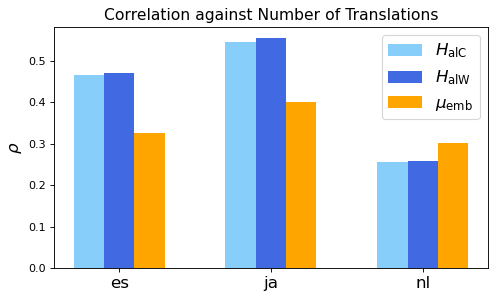

In [203]:
from collections import OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure

langs = ["es", "ja", "nl"]
methods = OrderedDict({"count": count_corr, "weight": weight_corr, "thompson": thompson_corr})
met_ent_latex = {"count": r"$H_{\mathrm{alC}}$", "weight": r"$H_{\mathrm{alW}}$", "thompson": r"$\mu_{\mathrm{emb}}$"}
met_latex = {"count": r"$P_{\mathrm{alC}}$", "weight": r"$P_{\mathrm{alW}}$", "thompson": r"$S_{\mathrm{emb}}$"}
nlangs = len(langs)
nmethods = len(methods)
met_colors = {"count": "lightskyblue", "weight":"royalblue", "thompson":"orange"}
x = np.arange(len(langs))
width = 0.2

def get_average_correlation(met, lang):
    if met["lang2en"][lang]["pval"] < 0.05 and  met["en2lang"][lang]["pval"] < 0.05:
        return (met["lang2en"][lang]["pcorr"]+met["en2lang"][lang]["pcorr"])/2
    else:
        return 0.0
    
figure(figsize=(7, 4), dpi=80)
# plot data in grouped manner of bar type
for metid, (met_name, met) in enumerate(list(methods.items())):
    ys = [get_average_correlation(met, lang) for lang in langs ]
    plt.bar(x+metid*width, ys, width, color=met_colors[met_name])

plt.xticks(x+(nmethods*width/2 - width/2), langs, fontsize=15)
# plt.xlabel("Languages")
plt.ylabel(r"$\rho$", fontsize=15)
plt.legend([met_ent_latex[met] for met in methods], fontsize=15)
plt.title("Correlation against Number of Translations", fontsize=14)
plt.savefig("figure/entropy-correlation.pdf", format="pdf", bbox_inches="tight")
plt.show()


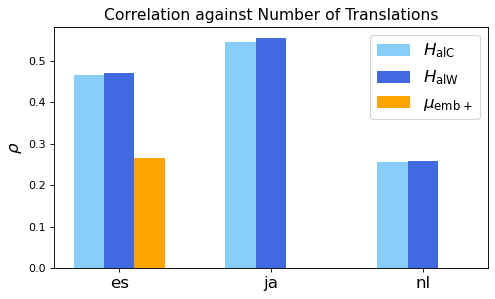

In [204]:
langs = ["es", "ja", "nl"]
figure(figsize=(7, 4), dpi=80)
methods = OrderedDict({"count": count_corr, "weight": weight_corr, "thompson": thompsonalg_corr})
# plot data in grouped manner of bar type
for metid, (met_name, met) in enumerate(list(methods.items())):
    ys = [get_average_correlation(met, lang) for lang in langs ]
    plt.bar(x+metid*width, ys, width, color=met_colors[met_name])

plt.xticks(x+(nmethods*width/2 - width/2), langs, fontsize=15)
# plt.xlabel("Languages")
plt.ylabel(r"$\rho$", fontsize=15)
plt.legend([met_ent_latex[met] if met!= "thompson" else r"$\mu_{\mathrm{emb+}}$" for met in methods], fontsize=15)
plt.title("Correlation against Number of Translations", fontsize=14)
plt.savefig("figure/entropy-alg-correlation.pdf", format="pdf", bbox_inches="tight")
plt.show()


## ii) Semantic Similarity

In [33]:
def get_word_pair_scores_from_file(filepath, w1col, w2col, value_col, delimiter=',', transform=float, latindecode=False):
    if latindecode:
        with open(filepath, "r", encoding="latin-1") as f:
            data = f.read().rstrip().split("\n")
    else:
        with open(filepath, "r", encoding="utf-8-sig") as f:
            data = f.read().rstrip().split("\n")
    columns = data[0].split(delimiter)
    w1colidx, w2colidx, vcolidx = columns.index(w1col), columns.index(w2col), columns.index(value_col)
    word_pair_alg = {}
    for line in data[1:]:
        line = line.replace('"', '').split(delimiter)
        try:
            if transform is None:
                w1, w2, val = line[w1colidx], line[w2colidx], line[vcolidx]
            else:
                w1, w2, val = line[w1colidx], line[w2colidx], transform(line[vcolidx])
        except:
            continue
        word_pair_alg[w1] = word_pair_alg.get(w1, {})
        word_pair_alg[w1][w2] = val
    return word_pair_alg

In [34]:
######## Semantic Similarity ########
semsim_fname = {"en-ja": "japanese-semantic-similarity.csv", "ja-en": "japanese-semantic-similarity.csv", "de-en":"german-tsv.csv", 
                "en-zh": "chinese-translation-ambiguity.csv", "zh-en": "chinese-translation-ambiguity.csv", 
                "en-nl": "dutch-similarityratings.csv", "nl-en": "dutch-similarityratings.csv"}

# X -> English
lang_en_semsim = {}
lang_en_semsim["ja"] = get_word_pair_scores_from_file(f'evaluation/translation-norms/{semsim_fname["ja-en"]}', 
                                               "Japanese name", "English name", value_col="Semantic similarity")
# lang_en_semsim["de"] = get_word_pair_scores_from_file(f'evaluation/translation-norms/{semsim_fname["de-en"]}', "German Word", "English Word", value_col="Averaged_TSV")
lang_en_semsim["nl"] = get_word_pair_scores_from_file(f'evaluation/translation-norms/{semsim_fname["nl-en"]}', "Dutch word", "English word", value_col="DE Semantic Sim Rating")
lang_en_semsim["zh"] = get_word_pair_scores_from_file(f'evaluation/translation-norms/{semsim_fname["zh-en"]}',  "Mandarin Word", "English Word",
                                                      value_col="Semantic Similarity Rating")

# English -> X
en_lang_semsim = {}
en_lang_semsim["ja"] = get_word_pair_scores_from_file(f'evaluation/translation-norms/{semsim_fname["en-ja"]}', "English name", "Japanese name", 
                                                      value_col="Semantic similarity")
en_lang_semsim["zh"] = get_word_pair_scores_from_file(f'evaluation/translation-norms/{semsim_fname["en-zh"]}', "English Word", "Mandarin Word", 
                                                      value_col="Semantic Similarity Rating")
en_lang_semsim["nl"] = get_word_pair_scores_from_file(f'evaluation/translation-norms/{semsim_fname["en-nl"]}', "English word", "Dutch word", 
                                                      value_col="ED Semantic Sim Rating")


In [170]:
print("--------- Normalised Alignment Surprisal (by alignment counts) against Semantic Similarity ---------")
count_ss_corr = word_correlation(lang_src_tar_fq_surp, en_src_tar_fq_surp, lang_en_semsim, en_lang_semsim, 
                                          ["ja", "nl", "zh"], ["ja", "nl", "zh"], word_pair=True, lang2en_vocab=lang_probs_vocab, en2lang_vocab=en_probs_vocab)
print_correlation(count_ss_corr, languages=["ja","nl","zh"])

--------- Normalised Alignment Surprisal (by alignment counts) against Semantic Similarity ---------
() -> en: pcorr, pval, scorr, spval
ja (184): -0.2, 0.007, -0.201, 0.006
nl (988): -0.587, 0.0, -0.583, 0.0
zh (1175): -0.474, 0.0, -0.487, 0.0

en -> (): pcorr, pval, scorr, spval
ja (184): -0.474, 0.0, -0.563, 0.0
nl (988): -0.476, 0.0, -0.507, 0.0
zh (1175): -0.486, 0.0, -0.557, 0.0

() <-> en: pcorr, pval, scorr, spval
ja: -0.337, 0.003, -0.382, 0.003
nl: -0.531, 0.0, -0.545, 0.0
zh: -0.48, 0.0, -0.522, 0.0


In [169]:
print("--------- Normalised Alignment Surprisal (by sum of weight) against Semantic Similarity ---------")
weight_ss_corr = word_correlation(lang_src_tar_weight_surp, en_src_tar_weight_surp, lang_en_semsim, en_lang_semsim, 
                                          ["ja", "nl", "zh"], ["ja", "nl", "zh"], word_pair=True, lang2en_vocab=lang_probs_vocab, en2lang_vocab=en_probs_vocab)
print_correlation(weight_ss_corr, languages=["ja","nl","zh"])

--------- Normalised Alignment Surprisal (by sum of weight) against Semantic Similarity ---------
() -> en: pcorr, pval, scorr, spval
ja (184): -0.194, 0.008, -0.19, 0.01
nl (988): -0.587, 0.0, -0.583, 0.0
zh (1175): -0.471, 0.0, -0.484, 0.0

en -> (): pcorr, pval, scorr, spval
ja (184): -0.471, 0.0, -0.561, 0.0
nl (988): -0.474, 0.0, -0.505, 0.0
zh (1175): -0.484, 0.0, -0.555, 0.0

() <-> en: pcorr, pval, scorr, spval
ja: -0.332, 0.004, -0.375, 0.005
nl: -0.531, 0.0, -0.544, 0.0
zh: -0.478, 0.0, -0.519, 0.0


In [216]:
print("--------- Negative Thompson's Alignment against Semantic Similarity ---------")
thompson_ss_corr = word_correlation(lang_en_thompson_neg, en_lang_thompson_neg, lang_en_semsim, en_lang_semsim, 
                                          ["ja", "nl", "zh"], ["ja", "nl", "zh"], word_pair=True, lang2en_vocab=lang_probs_vocab, en2lang_vocab=en_probs_vocab)
print_correlation(thompson_ss_corr, languages=["ja", "nl", "zh"])

print("\n--------- Negative Thompson's + alignment data against Semantic Similarity ---------")
thompsonalg_ss_corr = word_correlation(lang_en_thompsonalg_neg, en_lang_thompsonalg_neg, lang_en_semsim, en_lang_semsim, 
                                          ["ja", "nl", "zh"], ["ja", "nl", "zh"], word_pair=True, lang2en_vocab=lang_probs_vocab, en2lang_vocab=en_probs_vocab)
print_correlation(thompsonalg_ss_corr, languages=["ja", "nl", "zh"])


print("\n--------- Negative Thompson's + subs embedding against Semantic Similarity ---------")
thompsonalg_ss_corr = word_correlation(lang_en_thompsonsub_neg, en_lang_thompsonsub_neg, lang_en_semsim, en_lang_semsim, 
                                          [ "nl"], ["nl"], word_pair=True, lang2en_vocab=lang_probs_vocab, en2lang_vocab=en_probs_vocab)
print_correlation(thompsonalg_ss_corr, languages=[ "nl"])

--------- Negative Thompson's Alignment against Semantic Similarity ---------
() -> en: pcorr, pval, scorr, spval
ja (184): -0.422, 0.0, -0.468, 0.0
nl (988): -0.302, 0.0, -0.262, 0.0
zh (1175): -0.332, 0.0, -0.311, 0.0

en -> (): pcorr, pval, scorr, spval
ja (184): -0.422, 0.0, -0.468, 0.0
nl (988): -0.284, 0.0, -0.272, 0.0
zh (1175): -0.332, 0.0, -0.311, 0.0

() <-> en: pcorr, pval, scorr, spval
ja: -0.422, 0.0, -0.468, 0.0
nl: -0.293, 0.0, -0.267, 0.0
zh: -0.332, 0.0, -0.311, 0.0

--------- Negative Thompson's + alignment data against Semantic Similarity ---------
() -> en: pcorr, pval, scorr, spval
ja (184): -0.316, 0.0, -0.35, 0.0
nl (988): -0.325, 0.0, -0.292, 0.0
zh (1175): -0.36, 0.0, -0.361, 0.0

en -> (): pcorr, pval, scorr, spval
ja (184): -0.316, 0.0, -0.35, 0.0
nl (988): -0.295, 0.0, -0.265, 0.0
zh (1175): -0.36, 0.0, -0.361, 0.0

() <-> en: pcorr, pval, scorr, spval
ja: -0.316, 0.0, -0.35, 0.0
nl: -0.31, 0.0, -0.278, 0.0
zh: -0.36, 0.0, -0.361, 0.0

--------- Negative Tho

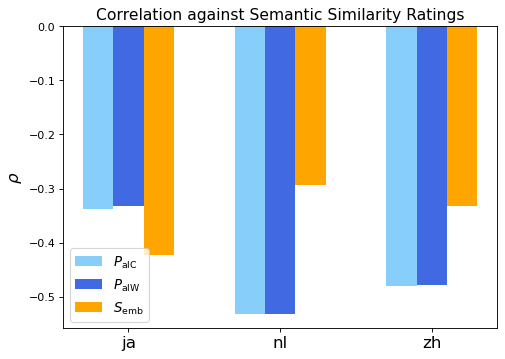

In [206]:
langs = ["ja", "nl", "zh"]
methods = OrderedDict({"count": count_ss_corr, "weight": weight_ss_corr, "thompson": thompson_ss_corr})
met_colors = {"count": "lightskyblue", "weight":"royalblue", "thompson":"orange"}
nlangs, nmethods = len(langs), len(methods)
x = np.arange(len(langs))
width = 0.2

figure(figsize=(7, 5), dpi=80)
# plot data in grouped manner of bar type
for metid, (met_name, met) in enumerate(list(methods.items())):
    ys = [get_average_correlation(met, lang) for lang in langs ]
    plt.bar(x+metid*width, ys, width, color=met_colors[met_name])

plt.xticks(x+(nmethods*width/2 - width/2), langs, fontsize=15)
# plt.xlabel("Languages")
plt.ylabel(r"$\rho$", fontsize=15)
plt.legend([met_latex[met] for met in methods], fontsize=12)
plt.title("Correlation against Semantic Similarity Ratings", fontsize=14)
plt.savefig("figure/semsim-correlation.pdf", format="pdf", bbox_inches="tight")
plt.show()


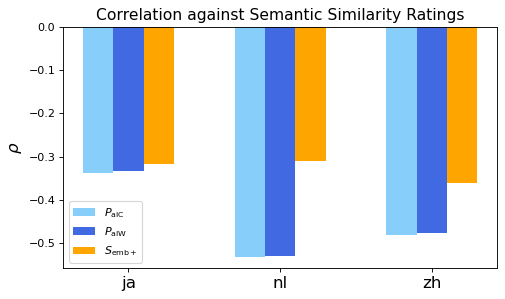

In [207]:
langs = ["ja", "nl", "zh"]
methods = OrderedDict({"count": count_ss_corr, "weight": weight_ss_corr, "thompson": thompsonalg_ss_corr})
met_colors = {"count": "lightskyblue", "weight":"royalblue", "thompson":"orange"}
nlangs, nmethods = len(langs), len(methods)
x = np.arange(len(langs))
width = 0.2

figure(figsize=(7, 4), dpi=80)
# plot data in grouped manner of bar type
for metid, (met_name, met) in enumerate(list(methods.items())):
    ys = [get_average_correlation(met, lang) for lang in langs ]
    plt.bar(x+metid*width, ys, width, color=met_colors[met_name])

plt.xticks(x+(nmethods*width/2 - width/2), langs, fontsize=15)
# plt.xlabel("Languages")
plt.ylabel(r"$\rho$", fontsize=15)
plt.legend([met_latex[met] if met != "thompson" else r"$S_{\mathrm{emb+}}$" for met in methods], fontsize=10)
plt.title("Correlation against Semantic Similarity Ratings", fontsize=14)
plt.savefig("figure/semsim-alg-correlation.pdf", format="pdf", bbox_inches="tight")
plt.show()


## iii) Behavioural Data

In [45]:
import glob
# All files and directories ending with .txt and that don't begin with a dot:
import math

def average_st_tprdb(files, word_col, value_col, filter_dict=None, log_value=False):
    all_readt = {}
    for file in glob.glob(files):
        try:
            readt = get_word_scores_from_file(file, word_col, [value_col], file_delimiter="\t", filter_dict=filter_dict)
            for w, rt in readt.items():
                rt = math.log(rt) if log_value else rt
                all_readt[w] = all_readt.get(w, []) + [rt]
        except:
            print(f"{value_col}:{file}")
    # return all_readt
    avg_readt = {}
    for w, rts in all_readt.items():
        avg_readt[w] = sum(rts)/len(rts)
    return avg_readt

# en_source_files = {"es": "evaluation/tprdbV310/BML12/Tables/*_T*.st", "ja": "evaluation/tprdbV310/ENJA15/Tables/*_T*.st", 
#                "de": "evaluation/tprdbV310/SG12/Tables/*_T*.st"}
en_source_files = {"es": "evaluation/tprdbV310/BML12/Tables/*.st", "ja": "evaluation/tprdbV310/ENJA15/Tables/*.st", 
               "de": "evaluation/tprdbV310/SG12/Tables/*.st"}
en_source_reading_time = {lang: average_st_tprdb(source_file, "SToken", "TrtS", filter_dict={"FPDurS": (lambda x: x >= 20)}, log_value=True) for lang, source_file in en_source_files.items()}
en_target_reading_time = {lang: average_st_tprdb(source_file, "SToken", "TrtT", filter_dict={"FPDurT": (lambda x: x >= 20)}, log_value=True)  for lang, source_file in en_source_files.items()}
en_source_munit = {lang: average_st_tprdb(source_file, "SToken", "Munit") for lang, source_file in en_source_files.items()}
en_source_htra = {lang: average_st_tprdb(source_file, "SToken", "HTra") for lang, source_file in en_source_files.items()}
en_source_dur = {lang: average_st_tprdb(source_file, "SToken", "Dur", filter_dict={"Dur": (lambda x: x >= 20)}, log_value=True) for lang, source_file in en_source_files.items()}
en_source_ineff = {lang: average_st_tprdb(source_file, "SToken", "InEff") for lang, source_file in en_source_files.items()}
en_source_hcross = {lang: average_st_tprdb(source_file, "SToken", "HCross") for lang, source_file in en_source_files.items()}
# en_source_edit = {lang: average_tprdb(source_file, "SToken", "Edit") for lang, source_file in en_source_files.items()}

# Inefficiency measure for segment generation. InEff = number of typed characters / length of final translation ≈ Insertions + Deletions / Insertions – Deletions +1
# FPDurS: First pass duration on source / target token. The first pass may include more than one fixation and can be referred to as first gaze.
# Edit: Sequence of keystrokes producing TT string
# Dur stands for duration and refers to the production duration of a TT token. It counts the time from the first keystroke to the last keystroke relating to 
# the typing of particular TT token
# PUnbr: Number of PUs contributing to the production of the translation

HTra:evaluation/tprdbV310/ENJA15/Tables/P33_D1.st
HTra:evaluation/tprdbV310/ENJA15/Tables/P24_P3.st
HCross:evaluation/tprdbV310/ENJA15/Tables/P33_D1.st
HCross:evaluation/tprdbV310/ENJA15/Tables/P24_P3.st


In [224]:
# en_tprdb_metric = {"source token reading time": en_source_reading_time, "target token reading time": en_target_reading_time, "number of micro units": en_source_munit,
#                "translation entropy (HTra)": en_source_htra, "production duration given a source token": en_source_dur, "inefficiency measure": en_source_ineff,
#                   "word reordering entropy (HCross)": en_source_hcross}

en_tprdb_metric = { "number of micro units": en_source_munit, "translation entropy (HTra)": en_source_htra, "production duration given a source token": en_source_dur}


print("--------- Alignment Count Entropy against ... ---------")
for met, vals in en_tprdb_metric.items():
    print(f"\n### {met} ###")
    corr = word_correlation(lang_src_tar_count_entropy, en_src_tar_count_entropy, {}, vals, 
                                              [], ["ja", "de", "es"], word_pair=False, lang2en_vocab=None, en2lang_vocab=en_vocab)
    print_correlation(corr, languages=[ "de", "es", "ja",])

--------- Alignment Count Entropy against ... ---------

### number of micro units ###

en -> (): pcorr, pval, scorr, spval
de (366): 0.267, 0.0, 0.277, 0.0
es (376): 0.112, 0.029, 0.095, 0.065
ja (246): -0.118, 0.065, -0.099, 0.123

### translation entropy (HTra) ###

en -> (): pcorr, pval, scorr, spval
de (366): 0.427, 0.0, 0.424, 0.0
es (376): 0.512, 0.0, 0.511, 0.0
ja (246): 0.406, 0.0, 0.394, 0.0

### production duration given a source token ###

en -> (): pcorr, pval, scorr, spval
de (362): 0.14, 0.008, 0.147, 0.005
es (376): 0.044, 0.399, 0.031, 0.551
ja (237): 0.058, 0.374, 0.057, 0.38


In [225]:
print("--------- Alignment Weight Entropy against ... ---------")
for met, vals in en_tprdb_metric.items():
    print(f"\n### {met} ###")
    corr = word_correlation(lang_src_tar_weight_entropy, en_src_tar_weight_entropy, {}, vals, 
                                              [], ["ja", "de", "es"], word_pair=False, lang2en_vocab=None, en2lang_vocab=en_vocab)
    print_correlation(corr, languages=[ "de", "es", "ja",])

--------- Alignment Weight Entropy against ... ---------

### number of micro units ###

en -> (): pcorr, pval, scorr, spval
de (366): 0.271, 0.0, 0.281, 0.0
es (376): 0.114, 0.027, 0.096, 0.062
ja (246): -0.108, 0.092, -0.089, 0.162

### translation entropy (HTra) ###

en -> (): pcorr, pval, scorr, spval
de (366): 0.428, 0.0, 0.428, 0.0
es (376): 0.511, 0.0, 0.511, 0.0
ja (246): 0.405, 0.0, 0.389, 0.0

### production duration given a source token ###

en -> (): pcorr, pval, scorr, spval
de (362): 0.152, 0.004, 0.163, 0.002
es (376): 0.052, 0.318, 0.037, 0.47
ja (237): 0.066, 0.31, 0.062, 0.339


In [226]:
print("--------- Thompson's lowest semantic alignment against ... ---------")
for met, vals in en_tprdb_metric.items():
    print(f"\n### {met} ###")
    corr = word_correlation(lang_en_thompson_minsim, en_lang_thompson_minsim, {}, vals, 
                                              [], ["ja", "de", "es"], word_pair=False, lang2en_vocab=None, en2lang_vocab=en_vocab)
    print_correlation(corr, languages=[ "de", "es", "ja",])

--------- Thompson's lowest semantic alignment against ... ---------

### number of micro units ###

en -> (): pcorr, pval, scorr, spval
de (366): 0.246, 0.0, 0.283, 0.0
es (376): 0.067, 0.193, 0.075, 0.146
ja (246): -0.046, 0.47, -0.039, 0.539

### translation entropy (HTra) ###

en -> (): pcorr, pval, scorr, spval
de (366): 0.322, 0.0, 0.34, 0.0
es (376): 0.298, 0.0, 0.296, 0.0
ja (246): 0.273, 0.0, 0.211, 0.001

### production duration given a source token ###

en -> (): pcorr, pval, scorr, spval
de (362): 0.0, 0.994, 0.054, 0.307
es (376): -0.126, 0.015, -0.11, 0.033
ja (237): 0.136, 0.036, 0.12, 0.064


In [227]:
print("--------- Thompson's lowest semantic alignment + alg data against ... ---------")
for met, vals in en_tprdb_metric.items():
    print(f"\n### {met} ###")
    corr = word_correlation(lang_en_thompsonalg_minsim, en_lang_thompsonalg_minsim, {}, vals, 
                                              [], ["ja", "de", "es"], word_pair=False, lang2en_vocab=None, en2lang_vocab=en_vocab)
    print_correlation(corr, languages=[ "de", "es", "ja",])

--------- Thompson's lowest semantic alignment + alg data against ... ---------

### number of micro units ###

en -> (): pcorr, pval, scorr, spval
de (366): 0.212, 0.0, 0.231, 0.0
es (375): 0.079, 0.127, 0.062, 0.234
ja (246): -0.099, 0.121, -0.088, 0.171

### translation entropy (HTra) ###

en -> (): pcorr, pval, scorr, spval
de (366): 0.332, 0.0, 0.34, 0.0
es (375): 0.314, 0.0, 0.296, 0.0
ja (246): 0.254, 0.0, 0.242, 0.0

### production duration given a source token ###

en -> (): pcorr, pval, scorr, spval
de (362): -0.055, 0.298, -0.019, 0.722
es (375): -0.196, 0.0, -0.207, 0.0
ja (237): 0.083, 0.203, 0.066, 0.314


In [221]:
print("--------- Thompson's lowest semantic alignment + sub emb against ... ---------")
for met, vals in en_tprdb_metric.items():
    print(f"\n### {met} ###")
    corr = word_correlation(lang_en_thompsonsub_minsim, en_lang_thompsonsub_minsim, {}, vals, 
                                              [], ["de", "es"], word_pair=False, lang2en_vocab=None, en2lang_vocab=en_vocab)
    print_correlation(corr, languages=[ "de", "es"])

--------- Thompson's lowest semantic alignment + sub emb against ... ---------

### source token reading time ###

en -> (): pcorr, pval, scorr, spval
de (355): -0.028, 0.596, -0.07, 0.188
es (376): -0.053, 0.304, -0.058, 0.259

### target token reading time ###

en -> (): pcorr, pval, scorr, spval
de (355): -0.033, 0.53, -0.028, 0.605
es (376): -0.076, 0.141, -0.071, 0.169

### number of micro units ###

en -> (): pcorr, pval, scorr, spval
de (355): 0.209, 0.0, 0.247, 0.0
es (376): 0.086, 0.096, 0.109, 0.034

### translation entropy (HTra) ###

en -> (): pcorr, pval, scorr, spval
de (355): 0.276, 0.0, 0.301, 0.0
es (376): 0.296, 0.0, 0.311, 0.0

### production duration given a source token ###

en -> (): pcorr, pval, scorr, spval
de (351): 0.013, 0.807, 0.079, 0.141
es (376): -0.069, 0.184, -0.044, 0.398

### inefficiency measure ###

en -> (): pcorr, pval, scorr, spval
de (355): 0.15, 0.005, 0.263, 0.0
es (376): 0.092, 0.076, 0.162, 0.002

### word reordering entropy (HCross) ###

en

In [49]:
def average_tt_tprdb(files, w1col, w2col, value_col, filter_val=0, log_value=False):
    all_readt = {}
    for file in glob.glob(files):
        try:
            readt = get_word_pair_scores_from_file(file, w1col, w2col, value_col, delimiter='\t')
            for w, trt in readt.items():
                w = w.lower()
                all_readt[w] = all_readt.get(w, {})
                for t, rt in trt.items():
                    if rt >= filter_val:
                        rt = math.log(rt) if log_value else rt
                        t = t.lower()
                        all_readt[w][t] = all_readt[w].get(t, []) + [rt]
        except:
            print(f"{value_col}: {file}")
    avg_readt = {}
    for w, trts in all_readt.items():
        w = w.lower()
        avg_readt[w] = {}
        for t, rts in trts.items():
            avg_readt[w][t] = sum(rts)/len(rts)
    return avg_readt

In [50]:
en_pair_files = {"es": "evaluation/tprdbV310/BML12/Tables/*.tt", "ja": "evaluation/tprdbV310/ENJA15/Tables/*.tt", 
               "de": "evaluation/tprdbV310/SG12/Tables/*.tt"}
en_tt_source_reading_time = {lang: average_tt_tprdb(source_file, "SToken", "TToken", "TrtS", filter_val=20, log_value=True) for lang, source_file in en_pair_files.items()}
en_tt_target_reading_time = {lang: average_tt_tprdb(source_file, "SToken", "TToken", "TrtT", filter_val=20, log_value=True) for lang, source_file in en_pair_files.items()}
en_tt_munit = {lang: average_tt_tprdb(source_file, "SToken", "TToken", "Munit") for lang, source_file in en_pair_files.items()}
en_tt_htra = {lang: average_tt_tprdb(source_file, "SToken", "TToken", "HTra") for lang, source_file in en_pair_files.items()}
en_tt_dur = {lang: average_tt_tprdb(source_file, "SToken", "TToken", "Dur", filter_val=20, log_value=True) for lang, source_file in en_pair_files.items()}
en_tt_ineff = {lang: average_tt_tprdb(source_file, "SToken", "TToken", "InEff") for lang, source_file in en_pair_files.items()}
en_tt_hcross = {lang: average_tt_tprdb(source_file, "SToken", "TToken", "HCross") for lang, source_file in en_pair_files.items()}

HTra: evaluation/tprdbV310/ENJA15/Tables/P24_P3.tt
HTra: evaluation/tprdbV310/ENJA15/Tables/P33_D1.tt
HCross: evaluation/tprdbV310/ENJA15/Tables/P24_P3.tt
HCross: evaluation/tprdbV310/ENJA15/Tables/P33_D1.tt


In [229]:
# en_tt_tprdb_metric = {"source token reading time": en_tt_source_reading_time, "target token reading time": en_tt_target_reading_time, "number of micro units": en_tt_munit,
#                       "production duration given a source token": en_tt_dur, "inefficiency measure": en_tt_ineff, "word reordering entropy (HCross)": en_tt_hcross}
en_tt_tprdb_metric = {"number of micro units": en_tt_munit, "production duration given a source token": en_tt_dur}

print("--------- Normalized alignment surpirsal (by count) against ... ---------")
for met, vals in en_tt_tprdb_metric.items():
    print(f"\n### {met} ###")
    corr = word_correlation(lang_src_tar_fq_surp, en_src_tar_fq_surp, {}, vals, 
                                              [], ["ja", "de", "es"], word_pair=True, lang2en_vocab=None, en2lang_vocab=en_probs_vocab)
    print_correlation(corr, languages=[ "de", "es", "ja",])

--------- Normalized alignment surpirsal (by count) against ... ---------

### number of micro units ###

en -> (): pcorr, pval, scorr, spval
de (1400): 0.269, 0.0, 0.334, 0.0
es (1697): 0.269, 0.0, 0.31, 0.0
ja (1334): 0.176, 0.0, 0.226, 0.0

### production duration given a source token ###

en -> (): pcorr, pval, scorr, spval
de (1330): -0.109, 0.0, -0.141, 0.0
es (1584): -0.195, 0.0, -0.241, 0.0
ja (809): -0.161, 0.0, -0.201, 0.0


In [230]:
print("--------- Normalized alignment probability (by weight) against ... ---------")
for met, vals in en_tt_tprdb_metric.items():
    print(f"\n### {met} ###")
    corr = word_correlation(lang_src_tar_weight_surp, en_src_tar_weight_surp, {}, vals, 
                                              [], ["ja", "de", "es"], word_pair=True, lang2en_vocab=None, en2lang_vocab=en_probs_vocab)
    print_correlation(corr, languages=[ "de", "es", "ja",])

--------- Normalized alignment probability (by weight) against ... ---------

### number of micro units ###

en -> (): pcorr, pval, scorr, spval
de (1400): 0.263, 0.0, 0.332, 0.0
es (1697): 0.26, 0.0, 0.305, 0.0
ja (1334): 0.17, 0.0, 0.224, 0.0

### production duration given a source token ###

en -> (): pcorr, pval, scorr, spval
de (1330): -0.12, 0.0, -0.149, 0.0
es (1584): -0.205, 0.0, -0.251, 0.0
ja (809): -0.156, 0.0, -0.196, 0.0


In [231]:
print("--------- Thompson's alignments against ... ---------")
for met, vals in en_tt_tprdb_metric.items():
    print(f"\n### {met} ###")
    corr = word_correlation(lang_en_thompson_neg, en_lang_thompson_neg, {}, vals, 
                                              [], ["ja", "de", "es"], word_pair=True, lang2en_vocab=None, en2lang_vocab=en_probs_vocab)
    print_correlation(corr, languages=[ "de", "es", "ja",])

--------- Thompson's alignments against ... ---------

### number of micro units ###

en -> (): pcorr, pval, scorr, spval
de (1400): 0.067, 0.013, 0.068, 0.011
es (1697): 0.022, 0.364, 0.033, 0.168
ja (1334): -0.002, 0.934, 0.008, 0.783

### production duration given a source token ###

en -> (): pcorr, pval, scorr, spval
de (1330): -0.363, 0.0, -0.416, 0.0
es (1584): -0.466, 0.0, -0.521, 0.0
ja (809): 0.043, 0.226, 0.007, 0.842


In [232]:
print("--------- Thompson's alignments + alg data against ... ---------")
for met, vals in en_tt_tprdb_metric.items():
    print(f"\n### {met} ###")
    corr = word_correlation(lang_en_thompsonalg_neg, en_lang_thompsonalg_neg, {}, vals, 
                                              [], ["ja", "de", "es"], word_pair=True, lang2en_vocab=None, en2lang_vocab=en_probs_vocab)
    print_correlation(corr, languages=[ "de", "es", "ja",])

--------- Thompson's alignments + alg data against ... ---------

### number of micro units ###

en -> (): pcorr, pval, scorr, spval
de (1400): 0.11, 0.0, 0.117, 0.0
es (1636): 0.075, 0.003, 0.091, 0.0
ja (1266): 0.016, 0.573, 0.034, 0.233

### production duration given a source token ###

en -> (): pcorr, pval, scorr, spval
de (1330): -0.339, 0.0, -0.397, 0.0
es (1526): -0.401, 0.0, -0.46, 0.0
ja (782): -0.014, 0.697, -0.047, 0.185


In [233]:
print("--------- Thompson's alignments + sub emb against ... ---------")
for met, vals in en_tt_tprdb_metric.items():
    print(f"\n### {met} ###")
    corr = word_correlation(lang_en_thompsonsub_neg, en_lang_thompsonsub_neg, {}, vals, 
                                              [], [ "de", "es"], word_pair=True, lang2en_vocab=None, en2lang_vocab=en_probs_vocab)
    print_correlation(corr, languages=[ "de", "es",])

--------- Thompson's alignments + sub emb against ... ---------

### number of micro units ###

en -> (): pcorr, pval, scorr, spval
de (1266): 0.064, 0.022, 0.064, 0.022
es (1691): 0.029, 0.236, 0.041, 0.095

### production duration given a source token ###

en -> (): pcorr, pval, scorr, spval
de (1203): -0.352, 0.0, -0.417, 0.0
es (1578): -0.497, 0.0, -0.552, 0.0


## Experimental Specifications

In [265]:

lang_data = {"weight_surp":lang_src_tar_weight_surp, "count_surp": lang_src_tar_fq_surp, "weight_ent":lang_src_tar_weight_entropy, "count_ent": lang_src_tar_count_entropy, 
             "thompson": lang_en_thompson_neg, "thompson_sub": lang_en_thompsonsub_neg, "thompson_alg": lang_en_thompsonalg_neg, "no_trans": lang_en_norm, "semsim": lang_en_semsim}
en_data = {"weight":en_src_tar_weight_surp, "count": en_src_tar_fq_surp, "weight_ent":en_src_tar_weight_entropy, "count_ent": en_src_tar_count_entropy, 
           "thompson": en_lang_thompson_neg, "thompson_sub": en_lang_thompsonsub_neg, "thompson_alg": en_lang_thompsonalg_neg, 
           "no_trans": en_lang_norm, "semsim": en_lang_semsim, "htra": en_source_htra, "munit": en_tt_munit, "dur": en_tt_dur}

for mea, measures in lang_data.items():
    print("\n")
    for lang in measures:
        v_sz = len(measures[lang])
        if not isinstance(list(measures[lang].values())[0], float) and not isinstance(list(measures[lang].values())[0], int):
            pr_sz = sum([len(list(tgtws.keys())) for srcw, tgtws in measures[lang].items()])
            print(f"{lang} -> en {mea.upper()}  vocab size: {v_sz}, number of pairs: {pr_sz}")
        else:
            print(f"{lang} -> en {mea.upper()}  vocab size: {v_sz}")

for mea, measures in en_data.items():
    print("\n")
    for lang in measures:
        v_sz = len(measures[lang])
        if not isinstance(list(measures[lang].values())[0], float) and not isinstance(list(measures[lang].values())[0], int):
            pr_sz = sum([len(list(tgtws.keys())) for srcw, tgtws in measures[lang].items()])
            print(f"en -> {lang} {mea.upper()}  vocab size: {v_sz}, number of pairs: {pr_sz}")
        else:
            print(f"en -> {lang} {mea.upper()}  vocab size: {v_sz}")

    



ja -> en WEIGHT_SURP  vocab size: 97723, number of pairs: 1341800
es -> en WEIGHT_SURP  vocab size: 1196704, number of pairs: 11795399
nl -> en WEIGHT_SURP  vocab size: 1070605, number of pairs: 9069320
ms -> en WEIGHT_SURP  vocab size: 116998, number of pairs: 936386
de -> en WEIGHT_SURP  vocab size: 1038009, number of pairs: 7510776
zh -> en WEIGHT_SURP  vocab size: 814965, number of pairs: 5577517


ja -> en COUNT_SURP  vocab size: 97723, number of pairs: 1341800
es -> en COUNT_SURP  vocab size: 1196704, number of pairs: 11795399
nl -> en COUNT_SURP  vocab size: 1070605, number of pairs: 9069320
ms -> en COUNT_SURP  vocab size: 116998, number of pairs: 936386
de -> en COUNT_SURP  vocab size: 1038009, number of pairs: 7510776
zh -> en COUNT_SURP  vocab size: 814965, number of pairs: 5577517


ja -> en WEIGHT_ENT  vocab size: 13542
es -> en WEIGHT_ENT  vocab size: 44468
nl -> en WEIGHT_ENT  vocab size: 33147
ms -> en WEIGHT_ENT  vocab size: 10733
de -> en WEIGHT_ENT  vocab size: 409

## Analysis

### a) Entropy distribution

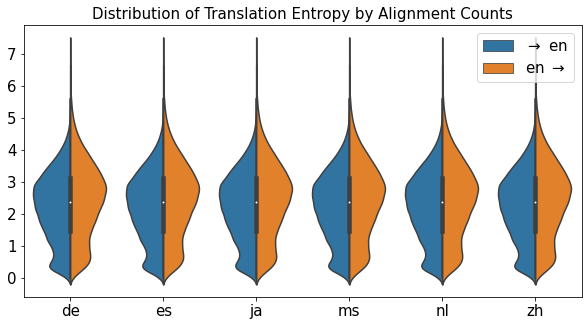

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd


language_names = {"en": "English", "ja": "Japanese", "nl": "Dutch", "zh": "Chinese", "ms": "Malay", "de": "German", "es": "Spanish"}

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(1*5.5, 1*3.5))
# mids = [(i, j) for i in range(1) for j in range(1)]
# fig.suptitle("Distribution of Translation Entropy by Alignment Counts", fontweight="bold", size=15)

lang_met_scores = {}
en_lang_met_scores = {}
for y_idx, lang in enumerate(languages):
    lang_met_scores[lang] = [v for lang, went in lang_src_tar_count_entropy.items() for v in went.values()]
    en_lang_met_scores[lang] = [v for lang, went in en_src_tar_count_entropy.items() for v in went.values()]
    
x = np.array([idx+1 for idx, lang in enumerate(languages) for _ in lang_met_scores[lang]] + [idx+1 for idx, lang in enumerate(languages) for _ in en_lang_met_scores[lang]])
y = np.array([sc  for lang in languages for sc in lang_met_scores[lang]] + [sc  for lang in languages for sc in en_lang_met_scores[lang]] )
hue = [r'$\rightarrow$ en'] * len([sc  for lang in languages for sc in lang_met_scores[lang]]) + \
[r'en $\rightarrow$'] * len([sc  for lang in languages for sc in en_lang_met_scores[lang]])

fig, ax = plt.subplots(figsize=(10, 5))
g = sns.violinplot(x=x, y=y, hue=hue, split=True, ax=ax)
g.set_xticklabels( languages, size=15)
g.yaxis.set_tick_params(labelsize=15)
# g.set_title(f"{metric_name[metric]}", size=15)
g.set_title("Distribution of Translation Entropy by Alignment Counts", size=15)
# g.get_legend().remove()
plt.legend(fontsize=15)
# lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
# lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
# fig.legend(lines[:2], labels[:2],loc='lower center', bbox_to_anchor=(0.5, -0.1), fontsize='x-large')
# fig.tight_layout()
plt.savefig("figure/entropy-dist-count.pdf", format="pdf", bbox_inches="tight")
plt.show()

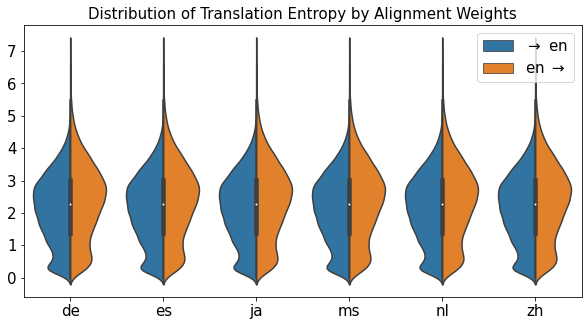

In [68]:
lang_met_scores = {}
en_lang_met_scores = {}
for y_idx, lang in enumerate(languages):
    lang_met_scores[lang] = [v for lang, went in lang_src_tar_weight_entropy.items() for v in went.values()]
    en_lang_met_scores[lang] = [v for lang, went in en_src_tar_weight_entropy.items() for v in went.values()]
x = np.array([idx+1 for idx, lang in enumerate(languages) for _ in lang_met_scores[lang]] + [idx+1 for idx, lang in enumerate(languages) for _ in en_lang_met_scores[lang]])
y = np.array([sc  for lang in languages for sc in lang_met_scores[lang]] + [sc  for lang in languages for sc in en_lang_met_scores[lang]] )
hue = [r'$\rightarrow$ en'] * len([sc  for lang in languages for sc in lang_met_scores[lang]]) + \
[r'en $\rightarrow$'] * len([sc  for lang in languages for sc in en_lang_met_scores[lang]])

fig, ax = plt.subplots(figsize=(10, 5))
g = sns.violinplot(x=x, y=y, hue=hue, split=True, ax=ax)
g.set_xticklabels(languages, size=15)
g.yaxis.set_tick_params(labelsize=15)
# g.set_title(f"{metric_name[metric]}", size=15)
g.set_title("Distribution of Translation Entropy by Alignment Weights", size=15)
# g.get_legend().remove()

# lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
# lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
# fig.legend(lines[:2], labels[:2],loc='lower center', bbox_to_anchor=(0.5, -0.1), fontsize='x-large')
# fig.tight_layout()
plt.legend(fontsize=15)
plt.savefig("figure/entropy-dist-weight.pdf", format="pdf", bbox_inches="tight")
plt.show()

### b) Cognates

In [69]:
# cognate_cols = {"ja": "Cognate status", "es": "cognate_rating", "nl": "Mean Form Sim Rating"}
lang_cognates = {}
lang_cognates["ja"] = get_word_pair_scores_from_file(f'evaluation/translation-norms/{semsim_fname["ja-en"]}', "Japanese name", "English name", 
                                                     "Cognate status", delimiter=',', transform=lambda x: 1 if x == "C" else 0)
lang_cognates["nl"] = get_word_pair_scores_from_file(f'evaluation/translation-norms/{semsim_fname["nl-en"]}', "Dutch word", "English word", "Mean Form Sim Rating", delimiter=',')
lang_cognates["es"] = get_word_pair_scores_from_file(f'evaluation/translation-norms/{norm_fname["es-en"]}', "Word", "Translation", "cognate_rating", delimiter=',', latindecode=True)

en_cognates = {}
en_cognates["ja"] = get_word_pair_scores_from_file(f'evaluation/translation-norms/{semsim_fname["ja-en"]}',  "English name", "Japanese name",
                                                     "Cognate status", delimiter=',', transform=lambda x: 1 if x == "C" else 0)
en_cognates["nl"] = get_word_pair_scores_from_file(f'evaluation/translation-norms/{semsim_fname["nl-en"]}',  "English word", "Dutch word", "Mean Form Sim Rating", delimiter=',')
en_cognates["es"] = get_word_pair_scores_from_file(f'evaluation/translation-norms/{norm_fname["en-es"]}', "Word", "Translation", "cognate_rating", delimiter=',', latindecode=True)

In [82]:
print("Correlation between Count Surprisal and Cognate Rating")
corr = word_correlation(lang_src_tar_fq_surp, en_src_tar_fq_surp,lang_cognates, en_cognates, ["nl", "es"], ["nl", "es"],  word_pair=True)
print_correlation(corr, languages=["es", "nl"])

Correlation between Count Surprisal and Cognate Rating
() -> en: pcorr, pval, scorr, spval
es (879): -0.176, 0.0, -0.221, 0.0
nl (988): -0.232, 0.0, -0.258, 0.0

en -> (): pcorr, pval, scorr, spval
es (788): -0.251, 0.0, -0.301, 0.0
nl (988): -0.195, 0.0, -0.186, 0.0

() <-> en: pcorr, pval, scorr, spval
es: -0.213, 0.0, -0.261, 0.0
nl: -0.214, 0.0, -0.222, 0.0


In [83]:
print("Correlation between Weight Surprisal and Cognate Rating")
corr = word_correlation(lang_src_tar_weight_surp, en_src_tar_weight_surp,lang_cognates, en_cognates, ["nl", "es"], ["nl", "es"],  word_pair=True)
print_correlation(corr, languages=["es", "nl"])

Correlation between Weight Surprisal and Cognate Rating
() -> en: pcorr, pval, scorr, spval
es (879): -0.177, 0.0, -0.223, 0.0
nl (988): -0.232, 0.0, -0.261, 0.0

en -> (): pcorr, pval, scorr, spval
es (788): -0.25, 0.0, -0.302, 0.0
nl (988): -0.196, 0.0, -0.187, 0.0

() <-> en: pcorr, pval, scorr, spval
es: -0.214, 0.0, -0.262, 0.0
nl: -0.214, 0.0, -0.224, 0.0


In [84]:
print("Correlation between Negative Thompson's Embedding Similarity and Cognate Rating")
corr = word_correlation(lang_en_thompson_neg, en_lang_thompson_neg, lang_cognates, en_cognates, ["nl", "es"], ["nl", "es"],  word_pair=True)
print_correlation(corr, languages=["es", "nl"])

Correlation between Negative Thompson's Embedding Similarity and Cognate Rating
() -> en: pcorr, pval, scorr, spval
es (896): -0.011, 0.753, 0.003, 0.922
nl (1000): -0.046, 0.146, -0.025, 0.431

en -> (): pcorr, pval, scorr, spval
es (792): -0.073, 0.04, -0.039, 0.272
nl (1000): -0.046, 0.146, -0.025, 0.431

() <-> en: pcorr, pval, scorr, spval
es: -0.042, 0.396, -0.018, 0.597
nl: -0.046, 0.146, -0.025, 0.431


In [74]:
from scipy.stats import ttest_ind

fq_norm_cognates, fq_norm_noncognates = [], []
weight_norm_cognates, weight_norm_noncognates = [],[]

for srcw, enw_cog in lang_cognates["ja"].items():
    if srcw in lang_src_tar_fq_surp["ja"]:
        for enw, cog in enw_cog.items():
            if enw in lang_src_tar_fq_surp["ja"][srcw]:
                if cog == 1:
                    fq_norm_cognates.append(lang_src_tar_fq_surp["ja"][srcw][enw])
                    weight_norm_cognates.append(lang_src_tar_weight_surp["ja"][srcw][enw])
                else:
                    fq_norm_noncognates.append(lang_src_tar_fq_surp["ja"][srcw][enw])
                    weight_norm_noncognates.append(lang_src_tar_weight_surp["ja"][srcw][enw])
                
        

print("T-test of Count Probability between cognates and non-cognates")
print(ttest_ind(fq_norm_cognates,fq_norm_noncognates))

print("\nT-test of Weight Probability between cognates and non-cognates")
print(ttest_ind(weight_norm_cognates, weight_norm_noncognates))

T-test of Count Probability between cognates and non-cognates
Ttest_indResult(statistic=-3.745573067301147, pvalue=0.00024100504773933056)

T-test of Weight Probability between cognates and non-cognates
Ttest_indResult(statistic=-3.5782249183113857, pvalue=0.00044286549481836426)


In [100]:
en_cognate_vocab = {lang: {enw: [langw for langw, cog in langwcog.items() if cog != 0] for enw, langwcog in en_cognates[lang].items()} for lang in ["ja", "es"]}
en_cognate_vocab = {lang: {enw: langws for enw, langws in enwlangws.items() if len(langws) > 0} for lang, enwlangws in en_cognate_vocab.items()}
en_noncognate_vocab = {lang: {enw: [langw for langw, cog in langwcog.items() if cog == 0] for enw, langwcog in en_cognates[lang].items()} for lang in ["ja", "es"]}
en_noncognate_vocab = {lang: {enw: langws for enw, langws in enwlangws.items() if len(langws) > 0} for lang, enwlangws in en_noncognate_vocab.items()}

In [113]:
print("--------- Surprisal against Duration with non-cognates ---------")
met='production duration given a source token'
vals = en_tt_tprdb_metric[met]
print(f"### {met} ###")
corr = word_correlation(lang_src_tar_fq_surp, en_src_tar_fq_surp, {}, vals, 
                                          [], ["es"], word_pair=True, lang2en_vocab=None, en2lang_vocab=en_noncognate_vocab)
print_correlation(corr, languages=["es"])


print("\n--------- Surprisal against Duration with cognates ---------")
met='production duration given a source token'
print(f"### {met} ###")
corr = word_correlation(lang_src_tar_fq_surp, en_src_tar_fq_surp, {}, vals, 
                                          [], ["es"], word_pair=True, lang2en_vocab=None, en2lang_vocab=en_cognate_vocab)
print_correlation(corr, languages=["es"])

print("\n--------- Surprisal against Duration with cognates and non-cognates ---------")
met='production duration given a source token'
print(f"### {met} ###")
corr = word_correlation(lang_src_tar_fq_surp, en_src_tar_fq_surp, {}, vals, 
                                          [], ["es"], word_pair=True, lang2en_vocab=None, en2lang_vocab=en_cognates)
print_correlation(corr, languages=["es"])


--------- Surprisal against Duration with non-cognates ---------
### production duration given a source token ###

en -> (): pcorr, pval, scorr, spval
es (16): -0.158, 0.558, -0.15, 0.579

--------- Surprisal against Duration with cognates ---------
### production duration given a source token ###

en -> (): pcorr, pval, scorr, spval
es (5): 0.888, 0.044, 0.7, 0.188

--------- Surprisal against Duration with cognates and non-cognates ---------
### production duration given a source token ###

en -> (): pcorr, pval, scorr, spval
es (21): -0.118, 0.609, -0.051, 0.827


In [199]:
word = "varied"
enw = word
lang = "es"
for langw in en_tt_tprdb_metric['production duration given a source token'][lang][word]:
    thomp_vals = en_lang_thompson_neg[lang].get(enw, {}).get(langw, "na")
    dur_vals = en_tt_tprdb_metric['production duration given a source token'][lang].get(enw, {}).get(langw, "na")
    probc_vals = en_src_tar_fq_surp[lang].get(enw, {}).get(langw, "na")
    probw_vals = en_src_tar_weight_surp[lang].get(enw, {}).get(langw, "na")
    frequency = f"{en_src_fq[lang][enw]}-{en_src_tar_fq[lang][enw].get(langw, 0)}"
    munit_vals = en_tt_tprdb_metric['number of micro units'][lang].get(enw, {}).get(langw, "na")
    
    print(f"{enw}-{langw}: {frequency}")
    print(f"thompson: {thomp_vals}")
    print(f"duration: {dur_vals}")
    print(f"munit: {munit_vals}")
    print(f"surpc: {probc_vals}")
    print(f"surpw: {probw_vals}")
    print("\n")


varied-diversa: 317.0-1.0
thompson: -0.6000534391529877
duration: 7.111512116496157
munit: 1.0
surpc: 5.75890177387728
surpw: 5.732720539455331


varied-variado: 317.0-41.0
thompson: -0.6275926454161566
duration: 7.146690117897557
munit: 1.2307692307692308
surpc: 2.045329707172973
surpw: 2.019507802117814


varied-distinto: 317.0-0
thompson: -0.3969269725617163
duration: 6.555356891810665
munit: 1.0
surpc: na
surpw: na


varied-diverso: 317.0-1.0
thompson: -0.5860516860354106
duration: 6.953684210870537
munit: 1.0
surpc: 5.75890177387728
surpw: 5.732720539455331


varied-variable: 317.0-2.0
thompson: -0.16060730682300595
duration: 7.527793987721444
munit: 1.0
surpc: 5.065754593317335
surpw: 5.039573358895385


varied-variada: 317.0-60.0
thompson: -0.5866038221321619
duration: 6.70073110954781
munit: 0.2222222222222222
surpc: 1.66455721165518
surpw: 1.639630448114679




In [181]:
word = "disliked"
enw = word
lang = "es"
for langw in en_tt_tprdb_metric['production duration given a source token'][lang][word]:
    thomp_vals = en_lang_thompson_neg[lang].get(enw, {}).get(langw, "na")
    dur_vals = en_tt_tprdb_metric['production duration given a source token'][lang].get(enw, {}).get(langw, "na")
    probc_vals = en_src_tar_fq_surp[lang].get(enw, {}).get(langw, "na")
    probw_vals = en_src_tar_weight_surp[lang].get(enw, {}).get(langw, "na")
    frequency = f"{en_src_fq[lang][enw]}-{en_src_tar_fq[lang][enw].get(langw, 0)}"
    print(f"{enw}-{langw}: {frequency}")
    print(f"thompson: {thomp_vals}")
    print(f"duration: {dur_vals}")
    # print(f"munit: {munit_vals}")
    print(f"surpc: {probc_vals}")
    print(f"surpw: {probw_vals}")
    print("\n")


disliked-a: 342.0-0
thompson: -0.09786047117063829
duration: 5.405630163831159
surpc: na
surpw: na


disliked-le: 342.0-0
thompson: -0.06471943005859644
duration: 5.396258873765665
surpc: na
surpw: na


disliked-disgustaba: 342.0-21.0
thompson: -0.5553237861828281
duration: 5.904812132142867
surpc: 2.790288299339182
surpw: 2.7149676087464876


disliked-no: 342.0-29.0
thompson: -0.0019758156926974364
duration: 5.493963669114265
surpc: 2.467514907076131
surpw: 2.6410134051354466


disliked-gustaba: 342.0-41.0
thompson: -0.522864875815134
duration: 7.2459878884428885
surpc: 2.1212386703582973
surpw: 2.0825916083712808


disliked-odiaba: 342.0-3.0
thompson: -0.6059156178573408
duration: 6.883685091318169
surpc: 4.736198448394496
surpw: 4.901908279716326


disliked-desagradaba: 342.0-15.0
thompson: -0.520633767448013
duration: 8.416930769477844
surpc: 3.126760535960395
surpw: 3.0515135102001403


disliked-cometió: 342.0-0
thompson: 0.025618182843384095
duration: 7.4489161025442
surpc: na
su

In [174]:
word = "region"
enw = word
lang = "es"
for langw in en_tt_tprdb_metric['production duration given a source token'][lang][word]:
    thomp_vals = en_lang_thompson_neg[lang].get(enw, {}).get(langw, "na")
    dur_vals = en_tt_tprdb_metric['production duration given a source token'][lang].get(enw, {}).get(langw, "na")
    probc_vals = en_src_tar_fq_surp[lang].get(enw, {}).get(langw, "na")
    probw_vals = en_src_tar_weight_surp[lang].get(enw, {}).get(langw, "na")
    # munit_vals = en_tt_tprdb_metric['number of micro units'][lang].get(enw, {}).get(langw, "na")
    frequency = f"{en_src_fq[lang][enw]}-{en_src_tar_fq[lang][enw].get(langw, 0)}"
    print(f"{enw}-{langw}: {frequency}")
    print(f"thompson: {thomp_vals}")
    print(f"duration: {dur_vals}")
    # print(f"munit: {munit_vals}")
    print(f"surpc: {probc_vals}")
    print(f"surpw: {probw_vals}")
    print("\n")


region-región: 3634.0-2941.0
thompson: -0.3926691729098437
duration: 8.009079805078985
surpc: 0.2115843104021213
surpw: 0.20383180373407025


region-estos: 3634.0-0
thompson: 4.593009895579106e-05
duration: 7.355641102974253
surpc: na
surpw: na


region-zona: 3634.0-235.0
thompson: -0.39105298970390273
duration: 7.363913501405819
surpc: 2.7385037348119576
surpw: 2.729626711924547


